### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [242]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [285]:
Paras = {
     'M0':['M0'],
    'e':['OMEGA','i0','omega','I_dot','Cus','Crs','e' , 'M0'],
    'sqrt_A':['Cuc','Crc','Del_n','Crs','sqrt_A','OMEGA_dot','Cus'],
    'OMEGA':['OMEGA','e','i0','omega'],
    'i0':['e','i0','omega','OMEGA' ,'I_dot'],
    'omega':['omega','e','OMEGA','i0'],
    'I_dot':['I_dot','e','Crs','Cuc'],
    'Cic':['M0','Cic'],
    'Cis':['Cis'],
    'OMEGA_dot':['OMEGA_dot','sqrt_A','Crc','Del_n','Cus' , 'omega' ],
    'Cuc':['Cuc','e','sqrt_A','I_dot','Crs'],
    'Cus':['Cus','sqrt_A','OMEGA_dot','Crc','Del_n','Cus'],
    'Crc':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Crs':['Crs','e','sqrt_A','I_dot','Cuc'],
    'Del_n':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Codes' : ['Codes']    
}

In [286]:
var_name = 'M0'
sat_var = 2

In [287]:
df = pd.read_csv("hourinterpol_21.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
#df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A'  ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
#       'Del_n', 'Cuc','Cus','Toe', 'Cic', 
#       'Cis', 'Crc', 'M0', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
#       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
#       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df = df.loc[:,Paras[var_name]]
#df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslib.Timestamp'>


,M0
Epoch_Time_of_Clock,
2017-11-02 00:00:00,-1.89937479229999994779
2017-11-02 01:00:00,-1.38905417190000002314
2017-11-02 02:00:00,-0.62038123130000000227
2017-11-02 03:00:00,0.44230021029999999627
2017-11-02 04:00:00,1.79602553300000011838


In [313]:
#df = df.iloc[5 : , :]
test = df.iloc[265:408,:]

In [289]:
df.head(7)

,M0
Epoch_Time_of_Clock,
2017-11-02 00:00:00,-1.89937479229999994779
2017-11-02 01:00:00,-1.38905417190000002314
2017-11-02 02:00:00,-0.62038123130000000227
2017-11-02 03:00:00,0.44230021029999999627
2017-11-02 04:00:00,1.79602553300000011838
2017-11-02 05:00:00,2.54955168759999972750
2017-11-02 06:00:00,1.03069561479999993736


# Enter number of entries per day

In [290]:
'''entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))'''
valid_start_dt = '2017-11-07 00:00:00'
test_start_dt = '2017-11-10 00:00:00'


Load data into Pandas dataframe

# enter lag and no. of outputs

In [291]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 24
HORIZON = 24

Create training set containing only the model features

In [292]:
train = df.copy()[df.index < valid_start_dt][Paras[var_name ]]
train.head()

,M0
Epoch_Time_of_Clock,
2017-11-02 00:00:00,-1.89937479229999994779
2017-11-02 01:00:00,-1.38905417190000002314
2017-11-02 02:00:00,-0.62038123130000000227
2017-11-02 03:00:00,0.44230021029999999627
2017-11-02 04:00:00,1.79602553300000011838


In [293]:
train.tail(6)

,M0
Epoch_Time_of_Clock,
2017-11-06 18:00:00,-1.93876304610000005368
2017-11-06 19:00:00,-2.19092661319999981728
2017-11-06 20:00:00,-2.37968474949999997392
2017-11-06 21:00:00,-2.47482573690000018374
2017-11-06 22:00:00,-2.44613785759999968761
2017-11-06 23:00:00,-2.26340939369999993858


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [294]:
from sklearn.preprocessing import StandardScaler




y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[Paras[var_name]] = X_scaler.fit_transform(train)

In [295]:
import pickle
file_x = open(var_name+'X_scaler2_5D_M0','wb')
pickle.dump(X_scaler, file_x)
            
file_y = open(var_name+'y_scalar2_5D_M0','wb')
pickle.dump(y_scalar, file_y)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [296]:
tensor_structure = {'X':(range(-T+1, 1), Paras[var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), Paras[var_name])} ,freq = None)

In [297]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00 -0.57043834512611757415 -0.16469855432471369738   
2017-11-03 00:00:00 -0.16469855432471369738  0.41176120662848286758   
2017-11-03 01:00:00  0.41176120662848286758  1.18001553271218972974   
2017-11-03 02:00:00  1.18001553271218972974  2.13454813226981343632   
2017-11-03 03:00:00  2.13454813226981343632  2.65825232256594823355   
2017-11-03 04:00:00  2.65825232256594823355  1.59692859907540340991   
2017-11-03 05:00:00  1.59692859907540340991 -0.51676933257836898949   
2017-11-03 06:00:00 -0.51676933257836898949 -1.51544456479151290473   
2017-11-03 07:00:00 -1.51544456479151290473 -0.96732320366197122041   
2017-11-03 08:00:00 -0.96732320366197122041 -0.21574822989903974513   
2017-11-03 09:00:00 -0.21574822989903974513  0.12232176506981444486   
2017-11-03 10:00:00  0.12232176506981444486  0.23080403008519737029   
2017-11-03 11:00:00  0.23080403008519737029  0.23180230878428600971   
2017-11-03 12:00:00  0.23180230878428600971  0.15060313191832885860   
2017-11-03 13:00:00  0.15060313191832885860  0.00828358607278223066   
2017-11-03 14:00:00  0.00828358607278223066 -0.17407924209719993769   
2017-11-03 15:00:00 -0.17407924209719993769 -0.37540826607585825458   
2017-11-03 16:00:00 -0.37540826607585825458 -0.57462639913834190342   
2017-11-03 17:00:00 -0.57462639913834190342 -0.75065655469919390086   
2017-11-03 18:00:00 -0.75065655469919390086 -0.88242164624265584383   
2017-11-03 19:00:00 -0.88242164624265584383 -0.94884458704387597550   
2017-11-03 20:00:00 -0.94884458704387597550 -0.92884829051739781214   
2017-11-03 21:00:00 -0.92884829051739781214 -0.80135567007776520310   
2017-11-03 22:00:00 -0.80135567007776520310 -0.54528963906982375054   
2017-11-03 23:00:00 -0.54528963906982375054 -0.13957311090811749810   
2017-11-04 00:00:00 -0.13957311090811749810  0.43687100099281039878   
2017-11-04 01:00:00  0.43687100099281039878  1.20511978328811353300   
2017-11-04 02:00:00  1.20511978328811353300  2.15965909845388726040   
2017-11-04 03:00:00  2.15965909845388726040  2.68337665340545461490   
2017-11-04 04:00:00  2.68337665340545461490  1.62206003959127209590   
...                                     ...                     ...   
2017-11-04 18:00:00 -0.72548031481675867571 -0.85725436280442934844   
2017-11-04 19:00:00 -0.85725436280442934844 -0.92368580492686180872   
2017-11-04 20:00:00 -0.92368580492686180872 -0.90369671774380289087   
2017-11-04 21:00:00 -0.90369671774380289087 -0.77620917781500009536   
2017-11-04 22:00:00 -0.77620917781500009536 -0.52014526176989694939   
2017-11-04 23:00:00 -0.52014526176989694939 -0.11442704616824074526   
2017-11-05 00:00:00 -0.11442704616824074526  0.46202339243022116921   
2017-11-05 01:00:00  0.46202339243022116921  1.23028397739604500316   
2017-11-05 02:00:00  1.23028397739604500316  2.18484113840148896912   
2017-11-05 03:00:00  2.18484113840148896912  2.70857694768826817722   
2017-11-05 04:00:00  2.70857694768826817722  1.64726761862992088226   
2017-11-05 05:00:00  1.64726761862992088226 -0.46643666209420031610   
2017-11-05 06:00:00 -0.46643666209420031610 -1.46512153615424089992   
2017-11-05 07:00:00 -1.46512153615424089992 -0.91700394634251680692   
2017-11-05 08:00:00 -0.91700394634251680692 -0.16542584414913669155   
2017-11-05 09:00:00 -0.16542584414913669155  0.17267971341976390276   
2017-11-05 10:00:00  0.17267971341976390276  0.28127885896919169184   
2017-11-05 11:00:00  0.28127885896919169184  0.28248950481915158228   
2017-11-05 12:00:00  0.28248950481915158228  0.20157655222699183417   
2017-11-05 13:00:00  0.20157655222699183417  0.05959390187513609327   
2017-11-05 14:00:00  0.05959390187513609327 -0.12240454548429451076   
2017-11-05 15:00:00 -0.1

In [298]:
train_inputs['target'].shape

(73, 24)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [299]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][Paras[var_name]]
valid[Paras[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                               target                         \
feature                                   y                          
time step                               t+1                    t+2   
Epoch_Time_of_Clock                                                  
2017-11-07 00:00:00 -0.06207949320798197834 0.51370373681981684744   
2017-11-07 01:00:00  0.51370373681981684744 1.28107594525384094197   
2017-11-07 02:00:00  1.28107594525384094197 2.23452142763676819825   
2017-11-07 03:00:00  2.23452142763676819825 2.75735838405976130261   
2017-11-07 04:00:00  2.75735838405976130261 1.69619131718043503199   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00  1.28107594525384094197  2.23452142763676819825   
2017-11-07 01:00:00  2.23452142763676819825  2.75735838405976130261   
2017-11-07 02:00:00  2.75735838405976130261  1.69619131718043503199   
2017-11-07 03:00:00  1.69619131718043503199 -0.41654255433266201836   
2017-11-07 04:00:00 -0.41654255433266201836 -1.41465985495816171102   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00  2.75735838405976130261  1.69619131718043503199   
2017-11-07 01:00:00  1.69619131718043503199 -0.41654255433266201836   
2017-11-07 02:00:00 -0.41654255433266201836 -1.41465985495816171102   
2017-11-07 03:00:00 -1.41465985495816171102 -0.86668176292371068570   
2017-11-07 04:00:00 -0.86668176292371068570 -0.11529874874981385635   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -0.41654255433266201836 -1.41465985495816171102   
2017-11-07 01:00:00 -1.41465985495816171102 -0.86668176292371068570   
2017-11-07 02:00:00 -0.86668176292371068570 -0.11529874874981385635   
2017-11-07 03:00:00 -0.11529874874981385635  0.22285588717818935467   
2017-11-07 04:00:00  0.22285588717818935467  0.33165590875464379117   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -0.86668176292371068570 -0.11529874874981385635   
2017-11-07 01:00:00 -0.11529874874981385635  0.22285588717818935467   
2017-11-07 02:00:00  0.22285588717818935467  0.33165590875464379117   
2017-11-07 03:00:00  0.33165590875464379117  0.33315335736551787704   
2017-11-07 04:00:00  0.33315335736551787704  0.25259089255367755955   

tensor                        ...                                 X  \
feature                       ...                                M0   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-07 00:00:00           ...            0.08500043873329092559   
2017-11-07 01:00:00           ...           -0.09698572016583571764   
2017-11-07 02:00:00           ...           -0.29795024526681301857   
2017-11-07 03:00:00           ...           -0.49683640206701512598   
2017-11-07 04:00:00           ...           -0.67258745613351322845   

tensor                                                               \
feature                                                               
time step                  

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [300]:
#Image('./images/simple_encoder_decoder.png')

In [301]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [302]:
LATENT_DIM = 32
BATCH_SIZE = 32
EPOCHS = 1000

In [303]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1 )))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [304]:
model.compile(optimizer='RMSprop', loss='mse')

In [305]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 32)                4352      
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 24, 32)            0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 24, 32)            8320      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 24, 1)             33        
_________________________________________________________________
flatten_12 (Flatten)         (None, 24)                0         
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [306]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [307]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [308]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 73 samples, validate on 48 samples
Epoch 1/1000
73/73 [==============================] - 4s 57ms/step - loss: 1.0111 - val_loss: 1.0066
Epoch 2/1000
73/73 [==============================] - 0s 3ms/step - loss: 1.0011 - val_loss: 0.9981
Epoch 3/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.9948 - val_loss: 0.9897
Epoch 4/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.9859 - val_loss: 0.9800
Epoch 5/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.9736 - val_loss: 0.9681
Epoch 6/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.9581 - val_loss: 0.9531
Epoch 7/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.9435 - val_loss: 0.9448
Epoch 8/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.9357 - val_loss: 0.9330
Epoch 9/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.9251 - val_loss: 0.9263
Epoch 10/1000
73/73 [==============================] - 

73/73 [==============================] - 0s 3ms/step - loss: 0.1690 - val_loss: 0.1731
Epoch 162/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.1324 - val_loss: 0.1908
Epoch 163/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1675 - val_loss: 0.1723
Epoch 164/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1315 - val_loss: 0.1892
Epoch 165/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1662 - val_loss: 0.1706
Epoch 166/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1304 - val_loss: 0.1872
Epoch 167/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1646 - val_loss: 0.1694
Epoch 168/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.1292 - val_loss: 0.1852
Epoch 169/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1631 - val_loss: 0.1696
Epoch 170/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1276 - val_loss: 0.

73/73 [==============================] - 0s 1ms/step - loss: 0.0555 - val_loss: 0.1326
Epoch 321/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 0.2469
Epoch 322/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0685 - val_loss: 0.1657
Epoch 323/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.1499 - val_loss: 0.4017
Epoch 324/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.1059 - val_loss: 0.3168
Epoch 325/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.1042 - val_loss: 0.3007
Epoch 326/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0861 - val_loss: 0.2377
Epoch 327/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0721 - val_loss: 0.2229
Epoch 328/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0576 - val_loss: 0.1272
Epoch 329/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0703 - val_loss: 0.

73/73 [==============================] - 0s 857us/step - loss: 0.0681 - val_loss: 0.1120
Epoch 401/1000
73/73 [==============================] - 0s 856us/step - loss: 0.1061 - val_loss: 0.1451
Epoch 402/1000
73/73 [==============================] - 0s 841us/step - loss: 0.0633 - val_loss: 0.1064
Epoch 403/1000
73/73 [==============================] - 0s 851us/step - loss: 0.1027 - val_loss: 0.1694
Epoch 404/1000
73/73 [==============================] - 0s 844us/step - loss: 0.0582 - val_loss: 0.0996
Epoch 405/1000
73/73 [==============================] - 0s 856us/step - loss: 0.1011 - val_loss: 0.2308
Epoch 406/1000
73/73 [==============================] - 0s 867us/step - loss: 0.0563 - val_loss: 0.0970
Epoch 407/1000
73/73 [==============================] - 0s 875us/step - loss: 0.0834 - val_loss: 0.3278
Epoch 408/1000
73/73 [==============================] - 0s 849us/step - loss: 0.0811 - val_loss: 0.2115
Epoch 409/1000
73/73 [==============================] - 0s 854us/step - loss: 0

73/73 [==============================] - 0s 962us/step - loss: 0.0599 - val_loss: 0.1013
Epoch 559/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0854 - val_loss: 0.0794
Epoch 560/1000
73/73 [==============================] - 0s 873us/step - loss: 0.0582 - val_loss: 0.0965
Epoch 561/1000
73/73 [==============================] - 0s 896us/step - loss: 0.0830 - val_loss: 0.0767
Epoch 562/1000
73/73 [==============================] - 0s 900us/step - loss: 0.0582 - val_loss: 0.0984
Epoch 563/1000
73/73 [==============================] - 0s 913us/step - loss: 0.0844 - val_loss: 0.0819
Epoch 564/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0989
Epoch 565/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0843 - val_loss: 0.0837
Epoch 566/1000
73/73 [==============================] - 0s 927us/step - loss: 0.0568 - val_loss: 0.0935
Epoch 567/1000
73/73 [==============================] - 0s 870us/step - loss: 0.0818 

73/73 [==============================] - 0s 878us/step - loss: 0.0461 - val_loss: 0.0884
Epoch 717/1000
73/73 [==============================] - 0s 891us/step - loss: 0.0674 - val_loss: 0.0641
Epoch 718/1000
73/73 [==============================] - 0s 880us/step - loss: 0.0425 - val_loss: 0.0836
Epoch 719/1000
73/73 [==============================] - 0s 917us/step - loss: 0.0643 - val_loss: 0.0684
Epoch 720/1000
73/73 [==============================] - 0s 927us/step - loss: 0.0396 - val_loss: 0.0826
Epoch 721/1000
73/73 [==============================] - 0s 827us/step - loss: 0.0634 - val_loss: 0.0751
Epoch 722/1000
73/73 [==============================] - 0s 903us/step - loss: 0.0404 - val_loss: 0.0875
Epoch 723/1000
73/73 [==============================] - 0s 886us/step - loss: 0.0661 - val_loss: 0.0777
Epoch 724/1000
73/73 [==============================] - 0s 872us/step - loss: 0.0395 - val_loss: 0.0855
Epoch 725/1000
73/73 [==============================] - 0s 862us/step - loss: 0

Epoch 796/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0228 - val_loss: 0.0706
Epoch 797/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.1376
Epoch 798/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.1223
Epoch 799/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0944 - val_loss: 0.0415
Epoch 800/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0477 - val_loss: 0.0579
Epoch 801/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0380
Epoch 802/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0486
Epoch 803/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0447
Epoch 804/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0674
Epoch 805/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0573

73/73 [==============================] - 0s 861us/step - loss: 0.0474 - val_loss: 0.0608
Epoch 956/1000
73/73 [==============================] - 0s 944us/step - loss: 0.0258 - val_loss: 0.0700
Epoch 957/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0528 - val_loss: 0.1084
Epoch 958/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0606
Epoch 959/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0413 - val_loss: 0.2196
Epoch 960/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0522 - val_loss: 0.1270
Epoch 961/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.1340
Epoch 962/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1018
Epoch 963/1000
73/73 [==============================] - 0s 953us/step - loss: 0.0217 - val_loss: 0.1023
Epoch 964/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0174 - val_lo

In [311]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

In [312]:
model.fit(valid_inputs['X'],
          valid_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=100,
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Epoch 1/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0333
Epoch 2/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0713
Epoch 3/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0787
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0305
Epoch 5/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 6/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0385
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0400
Epoch 8/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0340
Epoch 9/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0379
Epoch 10/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0266
Epoch 11/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0291
Epoch 12/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 13/100
48/48 [=================

## Evaluate the model

In [314]:
#look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
#test = df.copy()[test_start_dt:][Paras[var_name]]
test[Paras[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                              target                         \
feature                                  y                          
time step                              t+1                    t+2   
Epoch_Time_of_Clock                                                 
2017-11-14 00:00:00 0.11293797528213517234 0.68870502934650812410   
2017-11-14 01:00:00 0.68870502934650812410 1.45604134509434257616   
2017-11-14 02:00:00 1.45604134509434257616 2.40942934174883882648   
2017-11-14 03:00:00 2.40942934174883882648 2.93220593122907358108   
2017-11-14 04:00:00 2.93220593122907358108 1.87101368573283965979   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00  1.45604134509434257616  2.40942934174883882648   
2017-11-14 01:00:00  2.40942934174883882648  2.93220593122907358108   
2017-11-14 02:00:00  2.93220593122907358108  1.87101368573283965979   
2017-11-14 03:00:00  1.87101368573283965979 -0.24169950632947606595   
2017-11-14 04:00:00 -0.24169950632947606595 -1.23976831516787089349   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00  2.93220593122907358108  1.87101368573283965979   
2017-11-14 01:00:00  1.87101368573283965979 -0.24169950632947606595   
2017-11-14 02:00:00 -0.24169950632947606595 -1.23976831516787089349   
2017-11-14 03:00:00 -1.23976831516787089349 -0.69174285883861330593   
2017-11-14 04:00:00 -0.69174285883861330593  0.05964818522434417458   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -0.24169950632947606595 -1.23976831516787089349   
2017-11-14 01:00:00 -1.23976831516787089349 -0.69174285883861330593   
2017-11-14 02:00:00 -0.69174285883861330593  0.05964818522434417458   
2017-11-14 03:00:00  0.05964818522434417458  0.39774202013515930210   
2017-11-14 04:00:00  0.39774202013515930210  0.50639288062069409690   

tensor                                                              \
feature                                                              
time step                               t+9                   t+10   
Epoch_Time_of_Clock                                                  
2017-11-14 00:00:00 -0.69174285883861330593 0.05964818522434417458   
2017-11-14 01:00:00  0.05964818522434417458 0.39774202013515930210   
2017-11-14 02:00:00  0.39774202013515930210 0.50639288062069409690   
2017-11-14 03:00:00  0.50639288062069409690 0.50765291784007460230   
2017-11-14 04:00:00  0.50765291784007460230 0.42678414277567988666   

tensor                        ...                                 X  \
feature                       ...                                M0   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-14 00:00:00           ...            0.25970496674182624863   
2017-11-14 01:00:00           ...            0.07774736921529465383   
2017-11-14 02:00:00           ...           -0.12318059675445605650   
2017-11-14 03:00:00           ...           -0.32202496803627195243   
2017-11-14 04:00:00           ...           -0.49773178170809218024   

tensor                                                               \
feature                                                               
time step                               t-8  

In [315]:
test_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00  0.11293797528213517234  0.68870502934650812410   
2017-11-14 01:00:00  0.68870502934650812410  1.45604134509434257616   
2017-11-14 02:00:00  1.45604134509434257616  2.40942934174883882648   
2017-11-14 03:00:00  2.40942934174883882648  2.93220593122907358108   
2017-11-14 04:00:00  2.93220593122907358108  1.87101368573283965979   
2017-11-14 05:00:00  1.87101368573283965979 -0.24169950632947606595   
2017-11-14 06:00:00 -0.24169950632947606595 -1.23976831516787089349   
2017-11-14 07:00:00 -1.23976831516787089349 -0.69174285883861330593   
2017-11-14 08:00:00 -0.69174285883861330593  0.05964818522434417458   
2017-11-14 09:00:00  0.05964818522434417458  0.39774202013515930210   
2017-11-14 10:00:00  0.39774202013515930210  0.50639288062069409690   
2017-11-14 11:00:00  0.50639288062069409690  0.50765291784007460230   
2017-11-14 12:00:00  0.50765291784007460230  0.42678414277567988666   
2017-11-14 13:00:00  0.42678414277567988666  0.28484029970932062126   
2017-11-14 14:00:00  0.28484029970932062126  0.10287513271371520607   
2017-11-14 15:00:00  0.10287513271371520607 -0.09805761406872008645   
2017-11-14 16:00:00 -0.09805761406872008645 -0.29690419649556981652   
2017-11-14 17:00:00 -0.29690419649556981652 -0.47261087042441779493   
2017-11-14 18:00:00 -0.47261087042441779493 -0.60412389171284808231   
2017-11-14 19:00:00 -0.60412389171284808231 -0.67038951621844466988   
2017-11-14 20:00:00 -0.67038951621844466988 -0.65035399972909435640   
2017-11-14 21:00:00 -0.65035399972909435640 -0.52296359824177651721   
2017-11-14 22:00:00 -0.52296359824177651721 -0.26716456754437695187   
2017-11-14 23:00:00 -0.26716456754437695187  0.13809683650551990430   
2017-11-15 00:00:00  0.13809683650551990430  0.71387435812002697499   
2017-11-15 01:00:00  0.71387435812002697499  1.48122174130216599508   
2017-11-15 02:00:00  1.48122174130216599508  2.43462105532528028107   
2017-11-15 03:00:00  2.43462105532528028107  2.95740584517403171105   
2017-11-15 04:00:00  2.95740584517403171105  1.89621274755930513400   
2017-11-15 05:00:00  1.89621274755930513400 -0.21650611416463502734   
...                                     ...                     ...   
2017-11-16 18:00:00 -0.41969306187061689029 -0.55086828703758250469   
2017-11-16 19:00:00 -0.55086828703758250469 -0.61686813448894894929   
2017-11-16 20:00:00 -0.61686813448894894929 -0.59666161149272056718   
2017-11-16 21:00:00 -0.59666161149272056718 -0.46921772531690147945   
2017-11-16 22:00:00 -0.46921772531690147945 -0.21350548322949625124   
2017-11-16 23:00:00 -0.21350548322949625124  0.19150610757118849414   
2017-11-17 00:00:00  0.19150610757118849414  0.76684803974745108235   
2017-11-17 01:00:00  0.76684803974745108235  1.53355130610098422395   
2017-11-17 02:00:00  1.53355130610098422395  2.48608563998100517978   
2017-11-17 03:00:00  2.48608563998100517978  3.00801180907220455651   
2017-11-17 04:00:00  3.00801180907220455651  1.94641360292359810735   
2017-11-17 05:00:00  1.94641360292359810735 -0.16625073123199515801   
2017-11-17 06:00:00 -0.16625073123199515801 -1.16423412212637567009   
2017-11-17 07:00:00 -1.16423412212637567009 -0.61623604057415160007   
2017-11-17 08:00:00 -0.61623604057415160007  0.13514792782469864374   
2017-11-17 09:00:00  0.13514792782469864374  0.47327084530409146979   
2017-11-17 10:00:00  0.47327084530409146979  0.58187609242895865780   
2017-11-17 11:00:00  0.58187609242895865780  0.58296935027924745576   
2017-11-17 12:00:00  0.58296935027924745576  0.50183618520545503205   
2017-11-17 13:00:00  0.50183618520545503205  0.35955694130278043064   
2017-11-17 14:00:00  0.35955694130278043064  0.17721196273611986016   
2017-11-17 15:00:00  0.1

In [316]:
test_inputs.dataframe.shape

(96, 48)

In [317]:
predictions = model.predict(test_inputs['X'])

In [318]:
predictions

array([[-0.360842   ,  0.012825832,  0.6550132  , ..., -0.7986915  ,
        -0.80790365 , -0.7224828  ],
       [ 0.018790543,  0.5708734  ,  1.3727506  , ..., -0.78595865 ,
        -0.5416479  , -0.2656097  ],
       [ 0.70171523 ,  1.4999878  ,  2.162906   , ..., -0.056615025,
         0.3476908  ,  0.7605046  ],
       ...,
       [-0.6896385  , -0.84850967 , -0.7240988  , ..., -0.5030329  ,
        -0.65682733 , -0.78777504 ],
       [-0.7133068  , -0.7591443  , -0.47326228 , ..., -0.6447253  ,
        -0.7648474  , -0.8665819  ],
       [-0.66595626 , -0.5727923  , -0.12582153 , ..., -0.7184372  ,
        -0.8085525  , -0.8701644  ]], dtype=float32)

In [319]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h              prediction                  actual
0 2017-11-14 00:00:00  t+1 -1.74364139316668609325 -1.06387280469999989663
1 2017-11-14 01:00:00  t+1 -1.19895337342632157807 -0.23777548800000003482
2 2017-11-14 02:00:00  t+1 -0.21910875020785769429  0.86318099599999986715
3 2017-11-14 03:00:00  t+1  1.19477260030713616779  2.23108014939999943493
4 2017-11-14 04:00:00  t+1  1.29222466177611061688  2.98114796720000008179
               timestamp     h              prediction                  actual
2299 2017-11-17 19:00:00  t+24 -2.00004300991324024395 -1.76328079699999995533
2300 2017-11-17 20:00:00  t+24 -2.19216706909323111319 -1.95236717599999964889
2301 2017-11-17 21:00:00  t+24 -2.35619510678137356052 -2.04770425199999994703
2302 2017-11-17 22:00:00  t+24 -2.46926540019289619821 -2.01904897500000002353
2303 2017-11-17 23:00:00  t+24 -2.47440545655158672389 -1.83615829509999994862
(2304, 4)


In [320]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    -0.54056223161909122688
t+10   -0.58831809305033733182
t+11   -0.56143555076852436070
t+12   -0.49107967337806740504
t+13   -0.38030507495235493787
t+14   -0.38175329136723257228
t+15   -0.40668371556026983171
t+16   -0.37507381536597139693
t+17   -0.34184347979079943158
t+18   -0.36908588467532660315
t+19   -1.02314156355784180441
t+2    -0.60147804675827176712
t+20   -1.05013114216113812027
t+21   -0.67178055566408712007
t+22   -0.62307185970411593789
t+23   -0.35942214379215425835
t+24   -0.03833999601887388281
t+3    -0.63344790010494544941
t+4    -0.57897631933290061301
t+5    -0.52183980025645437806
t+6    -0.53243741596599225563
t+7    -0.54977435935495411190
t+8    -0.58728807657759740657
t+9    -0.59762770956809274647
Name: APE, dtype: float64

In [321]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

0.620122709303431

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

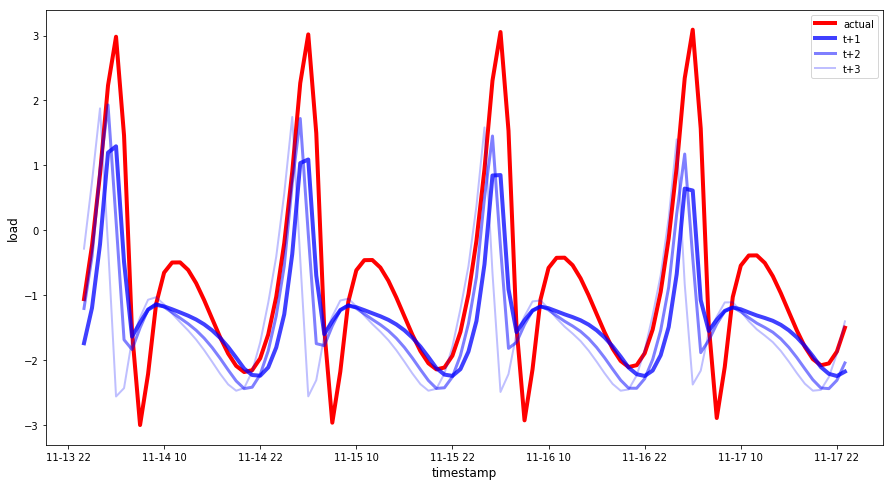

In [322]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [324]:
a = df.iloc[456:480  , :]
Actual = df.iloc[480:504,:]

In [325]:
new_df = pd.DataFrame()

In [326]:
columns = Paras[var_name] 

In [327]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [328]:
new_df = new_df.dropna( how = 'any')

In [329]:
new_df

,M0
Epoch_Time_of_Clock,
2017-11-21 00:00:00,-1.38852745789999998394
2017-11-21 01:00:00,-0.80740867449999997874
2017-11-21 02:00:00,0.01809125560000000160
2017-11-21 03:00:00,1.11814508940000001402
2017-11-21 04:00:00,2.48481641060000013610
2017-11-21 05:00:00,3.23365782200000007052
2017-11-21 06:00:00,1.71050355629999994989
2017-11-21 07:00:00,-1.32069128750000008843
2017-11-21 08:00:00,-2.75258139160000014911


In [330]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 22)

In [331]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [332]:
date

DatetimeIndex(['2017-11-22 00:00:00', '2017-11-22 01:00:00',
               '2017-11-22 02:00:00', '2017-11-22 03:00:00',
               '2017-11-22 04:00:00', '2017-11-22 05:00:00',
               '2017-11-22 06:00:00', '2017-11-22 07:00:00',
               '2017-11-22 08:00:00', '2017-11-22 09:00:00',
               '2017-11-22 10:00:00', '2017-11-22 11:00:00',
               '2017-11-22 12:00:00', '2017-11-22 13:00:00',
               '2017-11-22 14:00:00', '2017-11-22 15:00:00',
               '2017-11-22 16:00:00', '2017-11-22 17:00:00',
               '2017-11-22 18:00:00', '2017-11-22 19:00:00',
               '2017-11-22 20:00:00', '2017-11-22 21:00:00',
               '2017-11-22 22:00:00', '2017-11-22 23:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='H')

In [333]:
new_df.index= date

In [334]:
new_df.columns

Index(['M0'], dtype='object')

In [335]:
print(new_df)
print(new_df.columns)

                                         M0
Epoch_Time_of_Clock                        
2017-11-22 00:00:00 -1.38852745789999998394
2017-11-22 01:00:00 -0.80740867449999997874
2017-11-22 02:00:00  0.01809125560000000160
2017-11-22 03:00:00  1.11814508940000001402
2017-11-22 04:00:00  2.48481641060000013610
2017-11-22 05:00:00  3.23365782200000007052
2017-11-22 06:00:00  1.71050355629999994989
2017-11-22 07:00:00 -1.32069128750000008843
2017-11-22 08:00:00 -2.75258139160000014911
2017-11-22 09:00:00 -1.96634470389999993500
2017-11-22 10:00:00 -0.88828386390000002582
2017-11-22 11:00:00 -0.40314408429999998296
2017-11-22 12:00:00 -0.24730661309999998898
2017-11-22 13:00:00 -0.24572703039999999053
2017-11-22 14:00:00 -0.36212643280000000878
2017-11-22 15:00:00 -0.56625920050000000394
2017-11-22 16:00:00 -0.82787971339999999465
2017-11-22 17:00:00 -1.11674235159999990508
2017-11-22 18:00:00 -1.40260149509999987316
2017-11-22 19:00:00 -1.65521152389999981480
2017-11-22 20:00:00 -1.844326818

In [336]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), [var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                         M0
Epoch_Time_of_Clock                        
2017-11-22 00:00:00 -0.11333736720168183232
2017-11-22 01:00:00  0.29168640326191069834
2017-11-22 02:00:00  0.86703709533615702654
2017-11-22 03:00:00  1.63374428878084598793
2017-11-22 04:00:00  2.58627652024353249516


In [337]:
print(new_new_df)
print(inputs['X'])

tensor                                    X                         \
feature                                  M0                          
time step                              t-23                   t-22   
Epoch_Time_of_Clock                                                  
2017-11-22 23:00:00 -0.11333736720168183232 0.29168640326191069834   

tensor                                                             \
feature                                                             
time step                             t-21                   t-20   
Epoch_Time_of_Clock                                                 
2017-11-22 23:00:00 0.86703709533615702654 1.63374428878084598793   

tensor                                                             \
feature                                                             
time step                             t-19                   t-18   
Epoch_Time_of_Clock                                                 
2017-11-22 23:00:00 2.58627

In [338]:
predictions = model.predict(inputs['X'])

In [339]:
predictions

array([[-0.69555223 , -0.7080109  , -0.38420668 ,  0.16706228 ,
         0.77637136 ,  1.6251872  ,  2.516977   ,  2.6629975  ,
         1.0166467  , -0.96054804 , -1.320213   , -0.5368179  ,
         0.07717085 ,  0.3254341  ,  0.37698978 ,  0.34440005 ,
         0.25931472 ,  0.12401387 , -0.065479815, -0.29674467 ,
        -0.51041925 , -0.6663852  , -0.78382814 , -0.8838568  ]],
      dtype=float32)

In [340]:
print(predictions.shape)


(1, 24)


In [341]:
results = predictions[-1, :]

In [342]:
results

array([-0.69555223 , -0.7080109  , -0.38420668 ,  0.16706228 ,
        0.77637136 ,  1.6251872  ,  2.516977   ,  2.6629975  ,
        1.0166467  , -0.96054804 , -1.320213   , -0.5368179  ,
        0.07717085 ,  0.3254341  ,  0.37698978 ,  0.34440005 ,
        0.25931472 ,  0.12401387 , -0.065479815, -0.29674467 ,
       -0.51041925 , -0.6663852  , -0.78382814 , -0.8838568  ],
      dtype=float32)

In [343]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,M0
0,-0.69555222988128662109
1,-0.70801091194152832031
2,-0.38420668244361877441
3,0.16706228256225585938
4,0.77637135982513427734
5,1.62518715858459472656
6,2.51697707176208496094
7,2.66299748420715332031
8,1.01664674282073974609
9,-0.96054804325103759766


In [344]:
res_df.index = date
res_df

,M0
Epoch_Time_of_Clock,
2017-11-22 00:00:00,-0.69555222988128662109
2017-11-22 01:00:00,-0.70801091194152832031
2017-11-22 02:00:00,-0.38420668244361877441
2017-11-22 03:00:00,0.16706228256225585938
2017-11-22 04:00:00,0.77637135982513427734
2017-11-22 05:00:00,1.62518715858459472656
2017-11-22 06:00:00,2.51697707176208496094
2017-11-22 07:00:00,2.66299748420715332031
2017-11-22 08:00:00,1.01664674282073974609


In [345]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [349]:
# final generated ouput
res_df['actual'] = Actual
res_df

,M0,actual
Epoch_Time_of_Clock,,
2017-11-22 00:00:00,-2.22387599945068359375,-1.36092824879999985122
2017-11-22 01:00:00,-2.24175143241882324219,-0.77888557010000003533
2017-11-22 02:00:00,-1.77716445922851562500,0.04812556299999999621
2017-11-22 03:00:00,-0.98621648550033569336,1.15035077060000001659
2017-11-22 04:00:00,-0.11199387907981872559,2.51988293480000002944
2017-11-22 05:00:00,1.10586750507354736328,3.27130196799999994894
2017-11-22 06:00:00,2.38538718223571777344,1.74856240499999993077
2017-11-22 07:00:00,2.59489393234252929688,-1.28411933670000011354
2017-11-22 08:00:00,0.23274770379066467285,-2.71702877330000003298


In [352]:
res_df.to_csv('SA2M0.csv')

In [350]:
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(res_df['M0'], res_df['actual'])
a

1.1254670169714485